# Synaptic Partner Prediction in FAFB

Analysis and visualization code to work with the synaptic partner predictions from Buhmann et al. 2019 and neuron
segmentation from Li et al. 2019.

November 2019, Stephan Gerhard <info@braincircuits.io> (Modified by Julia Buhmann - December 2019)

### Prerequisites

* Download the SQLite database dump of all synaptic partner predictions and store it locally:
    * [download link](https://cremi.org/static/data/20191211_fafbv14_buhmann2019_li20190805.db) (14 gb, 244 million putative synaptic links)
* The following Python packages are required:
    * [pandas](https://pandas.pydata.org/)
    * [matplotlib](https://matplotlib.org/)
    * [sqlite3](https://docs.python.org/3/library/sqlite3.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sqlite3
def get_links(seg_id, cursor, where='segmentid_pre', table='synlinks',
              voxel_size=(40, 4, 4), filter_autapses=True, score_thr=60):
    cols = ['pre_x', 'pre_y', 'pre_z', 'post_x', 'post_y',
            'post_z', 'scores', 'segmentid_pre', 'segmentid_post', 'cleft_scores']
    seg_id_to_links = {}

    cursor.execute(
        'SELECT {} from {} where {} = {};'.format(','.join(cols), table,
                                                  where, seg_id))
    pre_links = cursor.fetchall()
    links = pd.DataFrame.from_records(pre_links, columns=cols)
    if filter_autapses:
        links = links[links.segmentid_pre != links.segmentid_post]
    if score_thr > 0:
        links = links[links.scores > score_thr]
    
    return links

### Connect to sqlite database dump

In [2]:
synaptic_predictions_dump_fname = '' # Put here the path to the downloaded file
conn = sqlite3.connect(synaptic_predictions_dump_fname)
c = conn.cursor()
c.execute('PRAGMA table_info(synlinks);').fetchall()

[(0, 'offset', 'INTEGER', 0, None, 0),
 (1, 'pre_x', 'REAL', 0, None, 0),
 (2, 'pre_y', 'REAL', 0, None, 0),
 (3, 'pre_z', 'REAL', 0, None, 0),
 (4, 'post_x', 'REAL', 0, None, 0),
 (5, 'post_y', 'REAL', 0, None, 0),
 (6, 'post_z', 'REAL', 0, None, 0),
 (7, 'scores', 'REAL', 0, None, 0),
 (8, 'cleft_scores', 'INTEGER', 0, None, 0),
 (9, 'segmentid_pre', 'INTEGER', 0, None, 0),
 (10, 'segmentid_post', 'INTEGER', 0, None, 0)]

### Retrieve all incoming-and outgoing synapses of a neuron segment 
- find a segment of interest in the [FAFB neuron segmentation from google](https://bit.ly/2ndprUu) or use a preselected segmentation ID


In [3]:
# Pick a neuron from the google fafb segmentation, or take one of the preselected
seg_id = 710435991 # Olfactory Projection Neuron 
# seg_id = 4217676680 # Neuron in Protocerebral Bridge

# retrieve all incoming and outgoing links
pre_links = get_links(seg_id, c, where='segmentid_pre')
post_links = get_links(seg_id, c, where='segmentid_post')
print('Loaded {} incoming and {} outgoing synaptic links for neuron segment id {}'.format(len(post_links), len(pre_links), seg_id))

Loaded 1824 incoming and 13801 outgoing synaptic links for neuron segment id 710435991


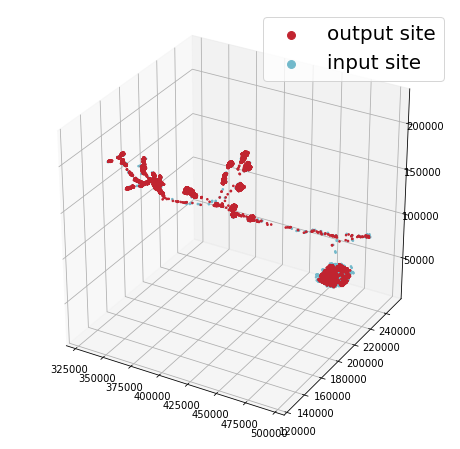

In [4]:
# plot skeleton with pre/post locations in 3d
input_site_color ='#72b9cb'
output_site_color = '#c12430'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pre_links.pre_x, pre_links.pre_y, pre_links.pre_z, color=output_site_color, s=2.5, alpha=1.0, label='output site')
ax.scatter(post_links.post_x, post_links.post_y, post_links.post_z, color=input_site_color, s=2.5, alpha=1.0, label='input site')


plt.legend(markerscale=5., scatterpoints=1, fontsize=20)

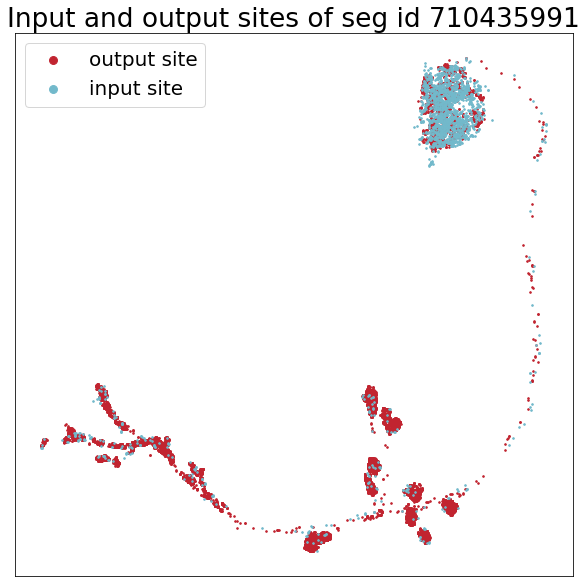

In [5]:
fig = plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
ax = fig.add_subplot(111)
ax.scatter(pre_links.pre_x, pre_links.pre_y, color=output_site_color, s=2.5, alpha=1.0, label='output site')
ax.scatter(post_links.post_x, post_links.post_y,  color=input_site_color, s=2.5, alpha=1.0, label='input site')
plt.xticks([])
plt.yticks([])
plt.title('Input and output sites of seg id {}'.format(seg_id))
plt.legend(markerscale=5., scatterpoints=1, fontsize=20)

# Query upstream and downstream neuron partners and show them in neuroglancer
* Additional dependency:
    * [networkx](https://networkx.github.io/)


In [6]:
# Pick a neuron from the google fafb segmentation, or take one of the preselected
seg_id = 710435991 # Olfactory Projection Neuron 
# seg_id = 4217676680 # Neuron in Protocerebral Bridge
top_k_partners = 5
minimum_edge_weight = 5

# retrieve all incoming and outgoing links
pre_links = get_links(seg_id, c, where='segmentid_pre')
post_links = get_links(seg_id, c, where='segmentid_post')

In [7]:
import networkx as nx
from IPython.core.display import display, HTML
# build a networkx graph of all segments where the edges reflect the synaptic count
g = nx.DiGraph()

for idx, r in pre_links.iterrows():
    from_id = int(r['segmentid_pre'])
    to_id = int(r['segmentid_post'])
    if (from_id,to_id) in g.edges:
        g.edges[(from_id,to_id)]['count'] += 1
    else:
        g.add_edge(from_id, to_id, count= 1)

for idx, r in post_links.iterrows():
    from_id = int(r['segmentid_pre'])
    to_id = int(r['segmentid_post'])
    if (from_id,to_id) in g.edges:
        g.edges[(from_id,to_id)]['count'] += 1
    else:
        g.add_edge(from_id, to_id, count= 1)



In [8]:
# Remove self-loops and 0-edge
g.remove_edges_from([(0, seg_id), (seg_id, 0), (seg_id, seg_id)])
        
# Filter 
edges_count = list(reversed(sorted(g.edges(data=True), key= lambda x: x[2]['count'])))
downstream_p = [k for k in edges_count if k[0] == seg_id and k[2]['count'] >= minimum_edge_weight]
upstream_p = [k for k in edges_count if k[1] == seg_id and k[2]['count'] >= minimum_edge_weight]
downstream_p = downstream_p[:min(len(downstream_p), top_k_partners)]
upstream_p = upstream_p[:min(len(upstream_p), top_k_partners)]

In [9]:
print(downstream_p)
print(upstream_p)

[(710435991, 8393408355, {'count': 26}), (710435991, 8257792369, {'count': 22}), (710435991, 1362998571, {'count': 18}), (710435991, 8393399853, {'count': 17}), (710435991, 8119602191, {'count': 16})]
[(1229930046, 710435991, {'count': 18}), (1101333317, 710435991, {'count': 11}), (1101341716, 710435991, {'count': 11}), (1230569923, 710435991, {'count': 11}), (972744791, 710435991, {'count': 10})]


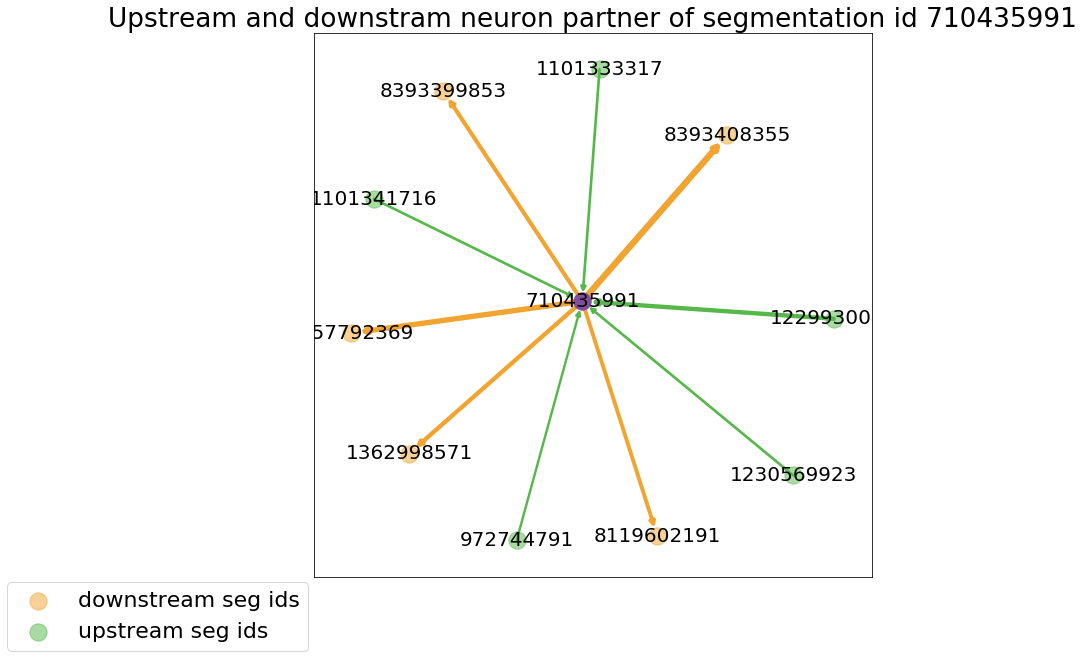

In [19]:
import numpy as np
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 22})
downstream_nodes = [k[1] for k in downstream_p]
upstream_nodes = [k[0] for k in upstream_p]
counts = [k[2]['count'] for k in downstream_p + upstream_p]
all_nodes = [seg_id] + downstream_nodes + upstream_nodes
sub_g = g.subgraph(all_nodes)

pos = nx.spring_layout(sub_g, k=5, weight='count')
nx.draw_networkx_nodes(sub_g, pos,  nodelist=downstream_nodes, node_color='#F2A431', label='downstream seg ids', alpha=0.5)
nx.draw_networkx_nodes(sub_g, pos,  nodelist=upstream_nodes, node_color="#55B849", label='upstream seg ids', alpha=0.5)
nx.draw_networkx_nodes(sub_g, pos, nodelist=[seg_id], node_color='#834D9D')
for edge in upstream_p:
    nx.draw_networkx_edges(sub_g, pos, edgelist=[edge],
                           width=[edge[2]['count']/np.median(counts)*4.], edge_color='#55B849')
for edge in downstream_p:
    nx.draw_networkx_edges(sub_g, pos, edgelist=[edge],
                           width=[edge[2]['count']/np.median(counts)*4.], edge_color='#F2A431')
plt.title('Upstream and downstram neuron partner of segmentation id {}'.format(seg_id))
res = nx.draw_networkx_labels(sub_g, pos, font_size=20)
plt.legend(bbox_to_anchor=(0.01, 0.01))

In [11]:
url = 'https://neuroglancer-demo.appspot.com/fafb.html#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://neuroglancer-fafb-data/fafb_v14/fafb_v14_orig%22%2C%22type%22:%22image%22%2C%22name%22:%22fafb_v14%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer-fafb-data/fafb_v14/fafb_v14_clahe%22%2C%22type%22:%22image%22%2C%22name%22:%22fafb_v14_clahe%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22mesh%22:%22precomputed://gs://neuroglancer-fafb-data/elmr-data/FAFBNP.surf/mesh%22%2C%22segments%22:%5B%221%22%2C%2210%22%2C%2211%22%2C%2212%22%2C%2213%22%2C%2214%22%2C%2215%22%2C%2216%22%2C%2217%22%2C%2218%22%2C%2219%22%2C%222%22%2C%2220%22%2C%2221%22%2C%2222%22%2C%2223%22%2C%2224%22%2C%2225%22%2C%2226%22%2C%2227%22%2C%2228%22%2C%2229%22%2C%223%22%2C%2230%22%2C%2231%22%2C%2232%22%2C%2233%22%2C%2234%22%2C%2235%22%2C%2236%22%2C%2237%22%2C%2238%22%2C%2239%22%2C%224%22%2C%2240%22%2C%2241%22%2C%2242%22%2C%2243%22%2C%2244%22%2C%2245%22%2C%2246%22%2C%2247%22%2C%2248%22%2C%2249%22%2C%225%22%2C%2250%22%2C%2251%22%2C%2252%22%2C%2253%22%2C%2254%22%2C%2255%22%2C%2256%22%2C%2257%22%2C%2258%22%2C%2259%22%2C%226%22%2C%2260%22%2C%2261%22%2C%2262%22%2C%2263%22%2C%2264%22%2C%2265%22%2C%2266%22%2C%2267%22%2C%2268%22%2C%2269%22%2C%227%22%2C%2270%22%2C%2271%22%2C%2272%22%2C%2273%22%2C%2274%22%2C%2275%22%2C%228%22%2C%229%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22neuropil-regions-surface%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22mesh%22%2C%22source%22:%22vtk://https://storage.googleapis.com/neuroglancer-fafb-data/elmr-data/FAFB.surf.vtk.gz%22%2C%22vertexAttributeSources%22:%5B%5D%2C%22shader%22:%22void%20main%28%29%20%7BemitRGBA%28vec4%281.0%2C%200.0%2C%200.0%2C%200.5%29%29%3B%7D%22%2C%22name%22:%22neuropil-full-surface%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://fafb-ffn1-20190805/segmentation%22%2C%22type%22:%22segmentation%22%2C%22segments%22:%5B%22'
url2 = '%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22fafb-ffn1-20190805%22%7D%2C%7B%22source%22:%22precomputed://gs://fafb-ffn1-20190805/segmentation%22%2C%22type%22:%22segmentation%22%2C%22skeletons%22:%22precomputed://gs://fafb-ffn1-20190805/segmentation/skeletons_32nm%22%2C%22selectedAlpha%22:0%2C%22segments%22:%5B%22'
url3 = '%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22skeletons_32nm%22%7D%2C%7B%22source%22:%22n5://gs://fafb-v14-synaptic-clefts-heinrich-et-al-2018-n5/synapses_dt_reblocked%22%2C%22type%22:%22image%22%2C%22opacity%22:0.73%2C%22shader%22:%22void%20main%28%29%20%7BemitRGBA%28vec4%280.0%2C0.0%2C1.0%2CtoNormalized%28getDataValue%28%29%29%29%29%3B%7D%22%2C%22name%22:%22clefts_Heinrich_etal%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22voxelCoordinates%22:%5B126620.234375%2C57437.2578125%2C3232.1064453125%5D%7D%7D%2C%22zoomFactor%22:35%7D%2C%22showAxisLines%22:false%2C%22perspectiveOrientation%22:%5B0.010064732283353806%2C0.054780226200819016%2C0.018741698935627937%2C-0.9982718229293823%5D%2C%22perspectiveZoom%22:2681.9999999999973%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22layer%22:%22fafb-ffn1-20190805%22%2C%22visible%22:true%7D%2C%22layout%22:%223d%22%7D'
connector = '%22%2C%22'
seg_ids = connector.join([str(node) for node in downstream_nodes + [seg_id]])
mainurl = url + seg_ids + url2 + seg_ids + url3
display(HTML("""<a href="{}">Neuroglancer link with downstream seg ids of seg id {}</a>""".format(mainurl, seg_id)))

In [12]:
seg_ids = connector.join([str(node) for node in upstream_nodes + [seg_id]])
mainurl = url + seg_ids + url2 + seg_ids + url3
display(HTML("""<a href="{}">Neuroglancer link with upstream seg ids of seg id {}</a>""".format(mainurl, seg_id)))